# Stereovision

![Suzanne](main.png)

Stereovision is a discipline that deals with the reconstruction of 3D information from images. For the reconstruction of a point, several images of this point are needed. These images must be taken from different points of view. The key step of the reconstruction, which is often problematic, is to identify the images of the point to be reconstructed in each view.

## Epipolar Geometry

Epipolar geometry involves two cameras. The epipolar geometry describes the geometric properties between two views of the same scene and depends only on the intrinsic parameters of the cameras and their relative positions. It provides, in particular, the epipolar constraint, which will be very useful to produce the matches between views.

## The Fondamental Matrix

![Epipolar Geometry - Sanyam Kapoor](epipolar.png)

Let us imagine that we have two images, right and left, of the world space. Let's take a point $\vec{x}$ in the right image space. The point $\vec{X}$ of the world space, of which $\vec{x}$ is the image, can be anywhere on the line passing through $\vec{x}$ and the optical center of the right camera. We will call this line the back-projected ray of $\vec{x}$. Let us note $\vec{x}'$ the image of $\vec{X}$ in the left image space. The locus of $\vec{x}'$ is therefore the image line of the back-projected ray of $\vec{x}$. This line is called the epipolar line and is denoted $\vec{l}'$. The epipolar line passes through the epipole $\vec{e}'$, image of the optical center of the right camera.

In 2D projective geometry, a line with equation $ax+by+c = 0$ is represented by a vector with three components $(a, b, c)^T$ defined to within one factor. Thus, we have the following relationship:

>The point $\vec{x}$ belongs to the line $\vec{l}$ if and only if $x^T\vec{l} = 0$.

Moreover, in 2D projective geometry, the following remarkable relations are valid:

- The intersection of two lines $l$ and $l'$ is given by $x = l \times l'$,
- The line passing through two points $x$ and $x'$ is given by $l = x \times x'$.

Note that the vector product can be written as a product of matrix $x \times y = [x]_\times y$ where

$$[x]_\times = \begin{pmatrix} 0 & −x3 & x2 \\ x3 & 0 & −x1 \\ −x2 & x1 & 0 \end{pmatrix}$$

To find the equation of the epipolar line in the left image space, we just need to find the coordinates of two points of this line. The first is the image $P'\vec{C}$ of the optical center $\vec{C}$ of the right camera where $P'$ is the projection matrix of the left camera. The second is $P'P^{+}\vec{x}$ where $P^{+}$ is the pseudo inverse of the projection matrix $P$ of the right camera. The epipolar line thus has the equation $l' = [P'\vec{C}]_\times{}P'P^{+}\vec{x} = F\vec{x}$ with $F = [P'\vec{C}]_\times{}P'P^{+}$. $F$ is called fundamental matrix.

Since the epipolar line $\vec{l}' = F\vec{x}$ is the locus of $\vec{x}'$, $\vec{x}'$ therefore belongs to $\vec{l}'$ which leads to the epipolar constraint :

>**The fundamental matrix is such that for any pair of points corresponding $\vec{x} \leftrightarrow \vec{x}'$ in the two images, we have $\vec{x}'^{T}F\vec{x} = 0$.**

## Computation of the fundamental matrix

The fundamental matrix $F$ has seven degrees of freedom. It has nine components but these are defined to within one scale factor, which removes one degree of freedom. Moreover, the matrix $F$ is a singular matrix ($det(F) = 0$) which gives us seven degrees of freedom. So we need at least seven correspondences to compute $F$. The equation $x'^{T}_iFx_i = 0$ and the seven correspondences allow us to write a system of equations of the form $Af = 0$, where $f$ is the vector which contains the components of the matrix $F$. Let us assume that $A$ is a 7×9 matrix of rank 7. The general solution of $Af = 0$ can be written $\alpha f_1 + (1-\alpha) f_2$ where $f_1$ and $f_2$ are two particular independent solutions of $Af = 0$. We then use the singularity constraint $det(\alpha F_1 + (1 - \alpha)F_2) = 0$ to determine $\alpha$. Since the singularity constraint gives rise to a third degree equation, we may have one or three solutions for $F$.

## OpenCV

In practice you will use the OpenCV library. In python, you have access to its functions through the `cv2` module.

You can find help with the calibration and reconstruction functions on the site https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html

## Goal

In the zip of the statement you will find two sequences of images taken by two cameras during the scanning of an object by a laser plane.

![Laser](scanRight/scan0010.png)

You will also find shots of a checkerboard in different positions that will help you calibrate your cameras.

![Damier](chessboards/c2Right.png)

The goal is to reconstruct the scanned object in 3D.

Now the following is the solution

## SOLUTION

### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv
import glob
import json
from utils import *
import cv2 as cv
import glob
import regex as re
from PIL import Image
from IPython.display import Image as IPImage, display
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas


### Variable initialisation


This section will calibrate the cameras constants for later stereovision    

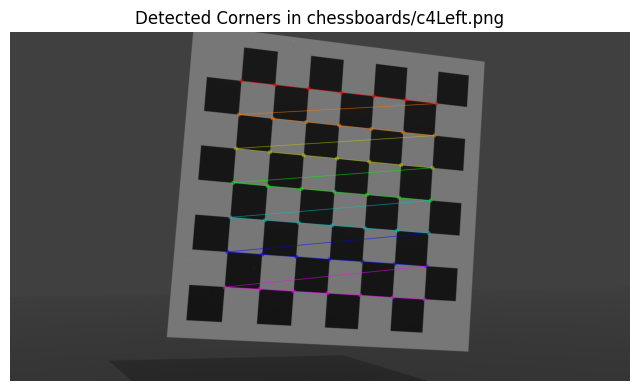

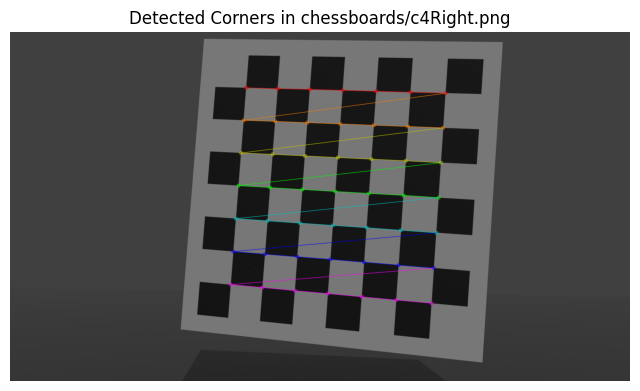

Camera Calibration Results:
Reprojection error: 0.04078596171871711
Camera matrix (mtx):
[[2.12475669e+03 0.00000000e+00 9.58709988e+02]
 [0.00000000e+00 2.12369889e+03 5.36536230e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients (dist):
[[-9.70456058e-03  3.39950947e-01 -9.49234347e-05  4.72026774e-06
  -3.27417678e+00]]
Rotation vectors (rvecs):
(array([[-0.06195956],
       [-0.18333823],
       [ 0.07810289]]), array([[-0.04710054],
       [ 0.21783908],
       [ 0.06865165]]))
Translation vectors (tvecs):
(array([[-2.28797749],
       [-3.64033621],
       [20.04354425]]), array([[-2.24506232],
       [-3.59326992],
       [20.93162404]]))
Fundamental Matrix (F):
 [[ 2.74271301e-06 -8.40505345e-07 -1.49979238e-03]
 [-1.50754095e-06  1.31982599e-06  4.34141990e-04]
 [-1.50143116e-03  6.66676294e-05  1.00000000e+00]]


In [2]:

# Define stopping criteria for corner refinement
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare 3D points of the checkerboard assuming it's flat (z=0)
objp = np.zeros((7 * 7, 3), np.float32)
objp[:, :2] = np.mgrid[0:7, 0:7].T.reshape(-1, 2)

# Lists to store 3D real-world points and 2D image points for all images
objpoints = []
imgpoints = []

# Load checkerboard images to calibrate the camera
images = glob.glob('chessboards/c4*.png')

# Loop over each image
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Detect checkerboard corners
    ret, corners = cv.findChessboardCorners(gray, (7, 7), None)

    if ret:  # If corners are successfully detected
        objpoints.append(objp)

        # Refine corner positions to sub-pixel accuracy
        corners = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners)

        # Draw corners on the image
        img_with_corners = img.copy()
        cv.drawChessboardCorners(img_with_corners, (7, 7), corners, ret)

        # Convert the image to RGB for Matplotlib
        img_rgb = cv.cvtColor(img_with_corners, cv.COLOR_BGR2RGB)

        # Plot using Matplotlib
        plt.figure(figsize=(8, 8))
        plt.imshow(img_rgb)
        plt.title(f"Detected Corners in {fname}")
        plt.axis("off")
        plt.show()

# Calibrate the camera using the collected 3D and 2D points
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Print calibration results
print("Camera Calibration Results:")
print(f"Reprojection error: {ret}")
print(f"Camera matrix (mtx):\n{mtx}")
print(f"Distortion coefficients (dist):\n{dist}")
print(f"Rotation vectors (rvecs):\n{rvecs}")
print(f"Translation vectors (tvecs):\n{tvecs}")


# Convert rotation vectors to rotation matrices
rot_mats = [cv.Rodrigues(rvec)[0] for rvec in rvecs]
# Why: Rotation vectors are converted to rotation matrices because they are easier to use in further computations 
# like creating projection matrices or performing triangulation.

# Compute projection matrices for each image
proj_mats = []
for i in range(len(rot_mats)):
    rot_trans_mat = np.hstack((rot_mats[i], tvecs[i]))  # Combine rotation and translation into a single matrix
    proj_mat = mtx @ rot_trans_mat  # Compute the projection matrix
    proj_mats.append(proj_mat)
# Why: Projection matrices encode how 3D points in the real world map to 2D image points, combining intrinsic 
# and extrinsic camera parameters.

# Compute the fundamental matrix between two images
# For simplicity, select two images to calculate the fundamental matrix
img1, img2 = images[:2]
gray1 = cv.cvtColor(cv.imread(img1), cv.COLOR_BGR2GRAY)
gray2 = cv.cvtColor(cv.imread(img2), cv.COLOR_BGR2GRAY)

# Detect ORB keypoints and descriptors
orb = cv.ORB_create()  # Create ORB detector
kp1, des1 = orb.detectAndCompute(gray1, None)
kp2, des2 = orb.detectAndCompute(gray2, None)
# Why: ORB is a fast and robust feature detector and descriptor that works well for finding matching points.

# Match keypoints using BFMatcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)
# Why: Feature matching identifies corresponding points between two images, which are needed to compute the 
# fundamental matrix and triangulate 3D points.

# Extract matched points
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
# Why: Extracting the coordinates of matched points allows further geometric computations.

# Compute the fundamental matrix
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)
print("Fundamental Matrix (F):\n", F)
# Why: The fundamental matrix encodes the geometric relationship between two images, 
# which is essential for tasks like epipolar geometry and 3D reconstruction.





In [3]:
# Convert rotation vectors to rotation matrices
rmatRight = cv.Rodrigues(rvecs[1])[0]  # Rotation matrix for the right camera
rmatLeft = cv.Rodrigues(rvecs[0])[0]  # Rotation matrix for the left camera
# Why: The Rodrigues transformation converts rotation vectors into 3x3 rotation matrices, 
# which are easier to work with when constructing projection matrices.

# Construct projection matrices by combining rotation and translation
rotMatRight = np.concatenate((rmatRight, tvecs[1]), axis=1)  # 3x4 matrix for the right camera
rotMatLeft = np.concatenate((rmatLeft, tvecs[0]), axis=1)  # 3x4 matrix for the left camera
# Why: The projection matrices encode how points in the 3D world are mapped to the 2D image planes of each camera.

# Compute the projection matrices of the cameras
camLeft = mtx @ rotMatLeft  # Projection matrix for the left camera
camRight = mtx @ rotMatRight  # Projection matrix for the right camera
# Why: These projection matrices combine intrinsic and extrinsic parameters, allowing us to project any 3D point 
# in the world onto the corresponding 2D image plane.

# Compute the world coordinates of the camera centers (homogeneous coordinates)
camWorldCenterLeft = np.linalg.inv(
    np.concatenate((rotMatLeft, [[0, 0, 0, 1]]), axis=0)
) @ np.transpose([[0, 0, 0, 1]])
camWorldCenterRight = np.linalg.inv(
    np.concatenate((rotMatRight, [[0, 0, 0, 1]]), axis=0)
) @ np.transpose([[0, 0, 0, 1]])
# Why: Calculating the camera centers in the world coordinate system is essential for understanding the geometry 
# of the scene and verifying the relative positions of the cameras.

print("Matrice de projection de la caméra gauche :")
print(camLeft)
print("\nMatrice de projection de la caméra droite :")
print(camRight)
# Why: Printing the projection matrices helps verify their correctness. These matrices are fundamental for computing 
# the epipolar geometry and reconstructing 3D points from image pairs.

Matrice de projection de la caméra gauche :
[[ 2.25490322e+03 -2.18533420e+02  5.48972174e+02  1.43545506e+04]
 [ 2.73045727e+02  2.07635312e+03  6.42006129e+02  3.02310971e+03]
 [ 1.79599491e-01 -6.86444748e-02  9.81341917e-01  2.00435442e+01]]

Matrice de projection de la caméra droite :
[[ 1.86108678e+03 -1.93011749e+02  1.39025835e+03  1.52971459e+04]
 [ 1.69462971e+01  2.09532306e+03  6.38202305e+02  3.59955132e+03]
 [-2.17479351e-01 -3.92310932e-02  9.75276193e-01  2.09316240e+01]]


### Plot les cameras dans l'espace

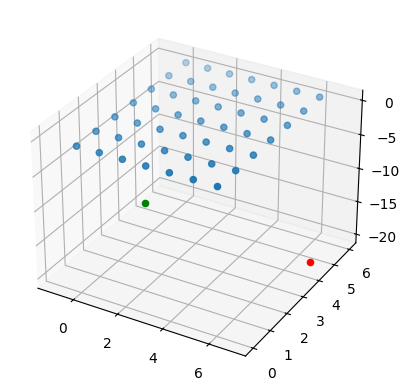

In [4]:
plotDotWorld(camWorldCenterLeft,camWorldCenterRight,objp)

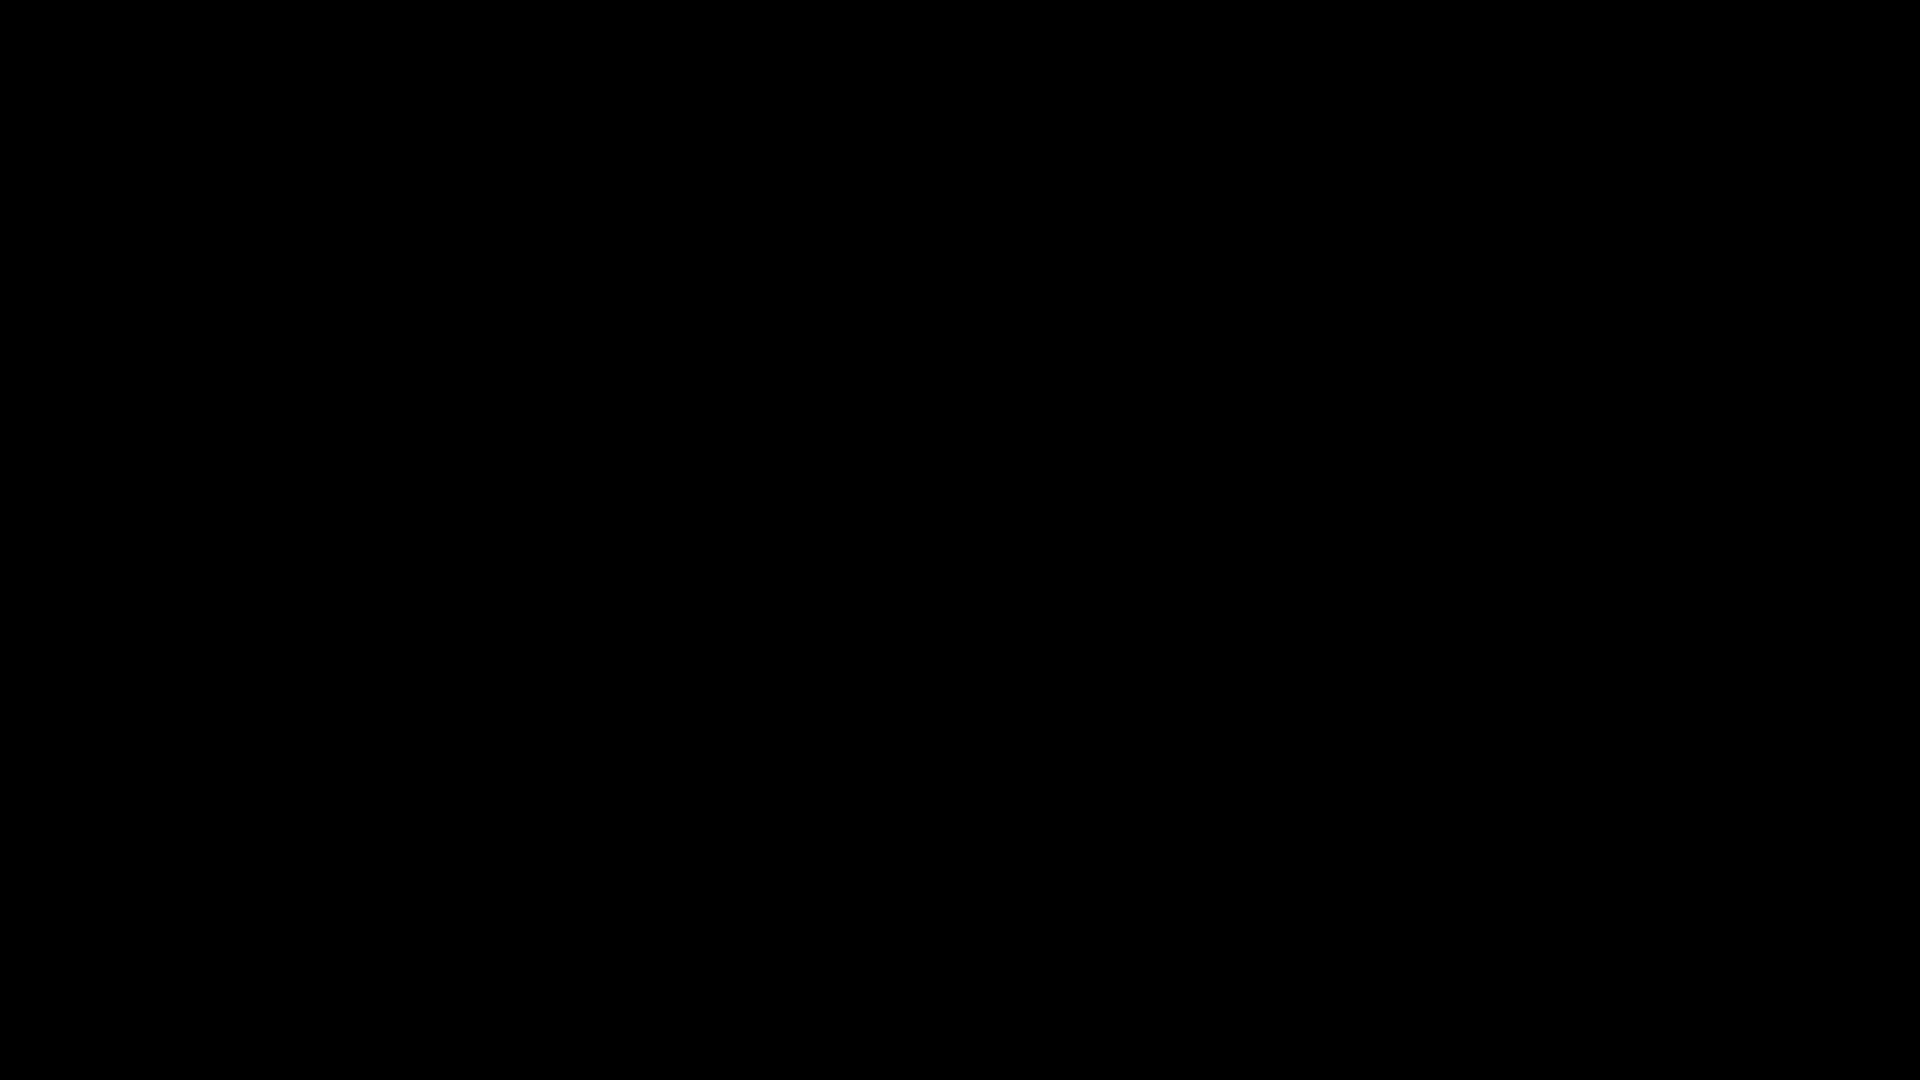

In [5]:
# Liste pour stocker les frames du GIF
frames = []

# Parcourir toutes les images du dossier spécifié (par exemple, "scanRight")
image_files = glob.glob("scanRight/*.png")  # Remplacez par votre chemin si nécessaire

for img_file in sorted(image_files):  # Trier pour garder un ordre cohérent
    # Charger l'image
    img = cv.imread(img_file)  # Charge chaque image dans une variable
    
    # Appliquer un seuil pour extraire la ligne
    ret, mask = cv.threshold(img, 127, 255, cv.THRESH_TOZERO)
    
    # Convertir le masque en format compatible avec PIL (RVB)
    mask_rgb = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
    pil_image = Image.fromarray(mask_rgb)  # Convertir l'image en objet PIL
    
    # Ajouter l'image traitée à la liste des frames
    frames.append(pil_image)

# Générer le GIF
output_gif_path = "output.gif"  # Nom du fichier GIF généré
frames[0].save(
    output_gif_path,
    save_all=True,
    append_images=frames[1:],  # Ajouter toutes les frames sauf la première
    duration=200,  # Durée de chaque frame en millisecondes
    loop=0  # 0 = boucle infinie
)

# Afficher le GIF dans Jupyter
display(IPImage(output_gif_path))

# Computing the Fundamental Matrix and Epipolar Geometry

## 1. Calculating the Fundamental Matrix

In this section, we compute the **Fundamental Matrix** (`Fondamental`), which defines the relationship between corresponding points in the left and right camera views.

### Code Explanation:
```python
Fondamental = matFondamental(camRight, camWorldCenterLeft, camLeft)


In [6]:
# Compute the Fundamental Matrix
Fondamental = matFondamental(camLeft, camWorldCenterLeft, camRight)
# This creates the fundamental matrix, which relates points in the left camera's view 
# to corresponding epipolar lines in the right camera's view.
# Inputs:
# - camRight: The projection matrix of the right camera (3x4).
# - camWorldCenterLeft: The position of the left camera in world coordinates (4x1 homogeneous).
# - camLeft: The projection matrix of the left camera (3x4).
# Process:
# The function combines the intrinsic and extrinsic camera parameters, along with
# the pseudo-inverse of the right camera matrix, to calculate a 3x3 fundamental matrix.
# Output:
# - Fondamental: Encodes the epipolar geometry between the two cameras.

# Compute the epipolar geometry for images in the 'scanLeft/' folder
epl = findEpilines('scanLeft/', Fondamental)
# This calculates the epilines for each image in the sequence located in 'scanLeft/'.
# Inputs:
# - 'scanLeft/': The folder containing the input images, which are assumed to show a laser line.
# - Fondamental: The fundamental matrix, used to compute epilines for each point.
# Process:
# - For each image in the folder:
#   1. `getImgLine` isolates the red laser line in the image (removes other details).
#   2. It calculates the average X position of red pixels for each row (laser line points).
#   3. These points (`pointsLeft`) are transformed using the fundamental matrix
#      to compute the corresponding epipolar lines (`epilinesRight`) in the right image.
# - The epipolar lines and points are stored for later use.
# Output:
# - `epl`: A list of `[pointsLeft, epilinesRight]` for all images.


### Drawing the EPLs

GIF créé : output_1.gif


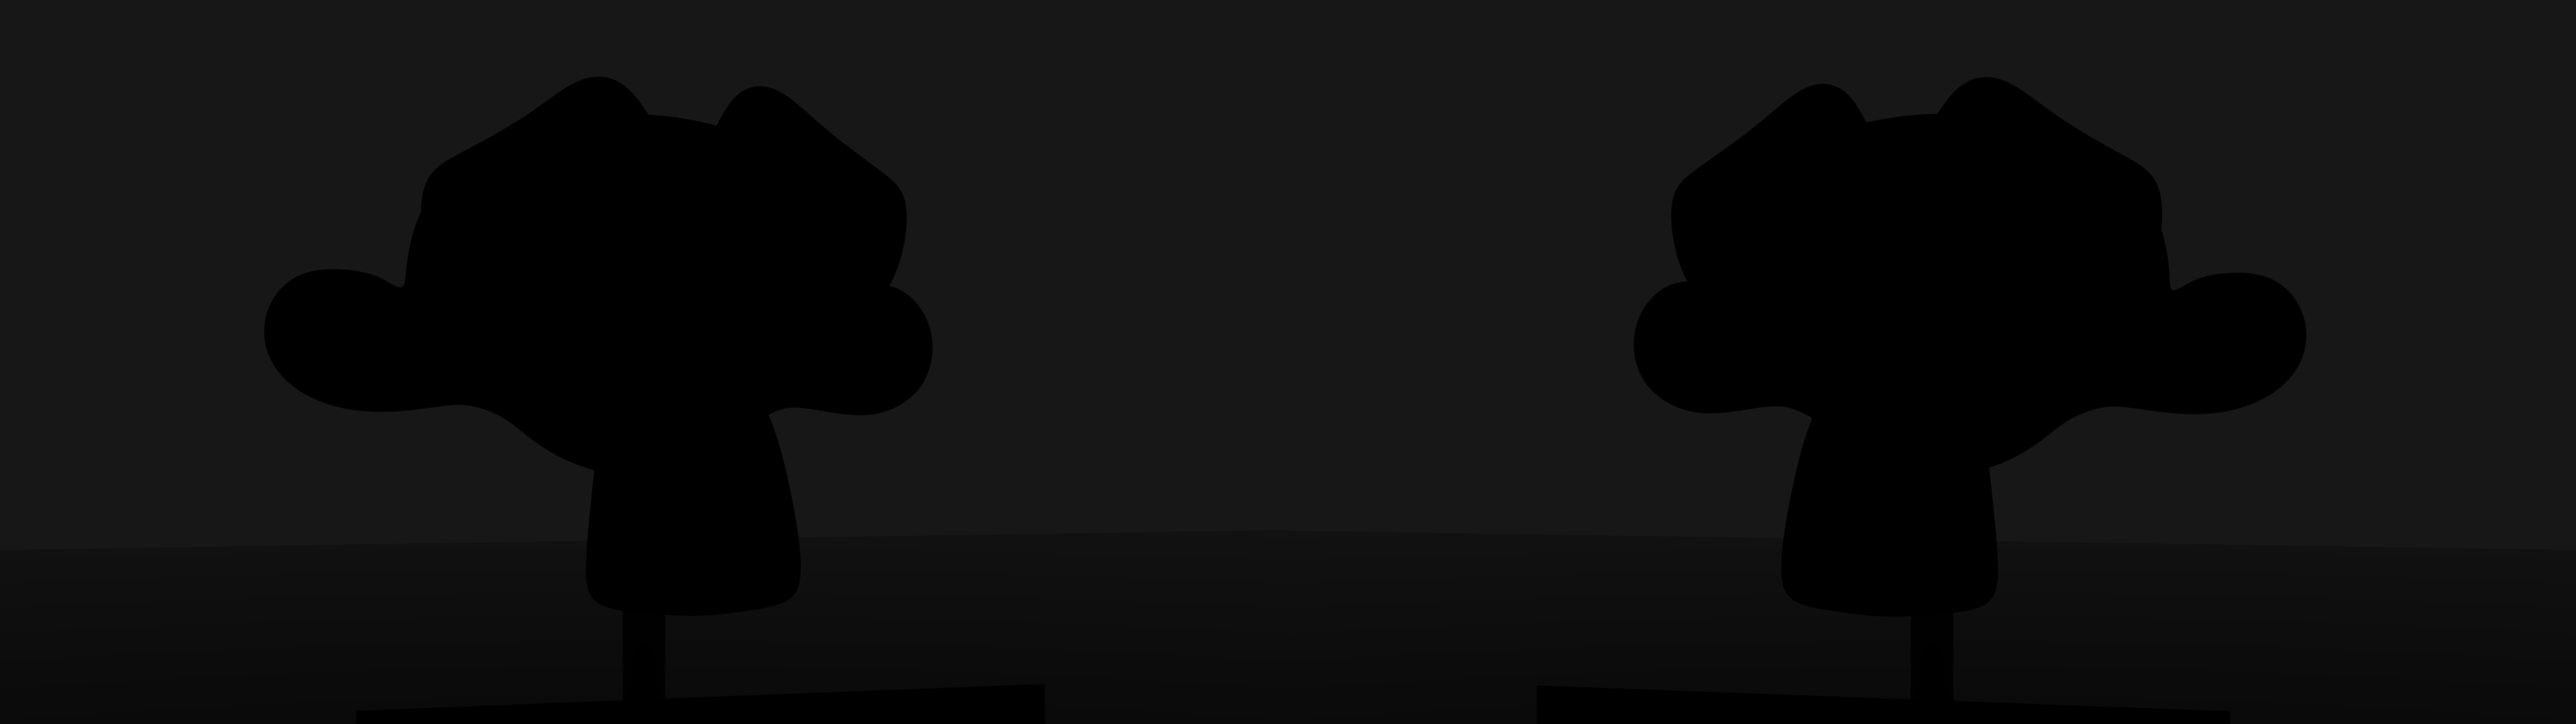

In [7]:

process_folder(
    left_folder='scanLeft',
    right_folder='scanRight',
    EplPointsLeft=[epl[i][0] for i in range(len(epl))],  
    EplRight=[epl[i][1] for i in range(len(epl))], 
    output_gif_path='output_1.gif',
    duration=300
)

display(pythImage(filename='output_1.gif'))



## Résultat avec plot

du singe avec rotation 360 degrés, vélocité rapide

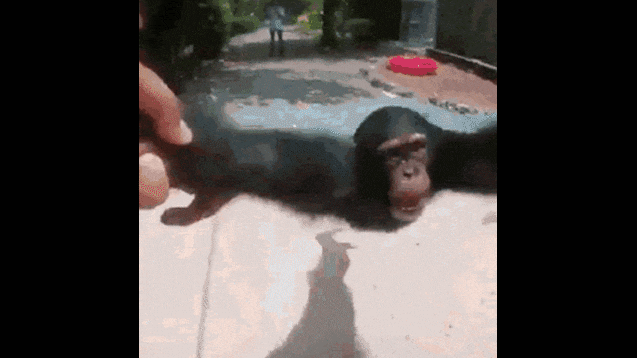

In [8]:
display(pythImage(filename='monkey.gif'))


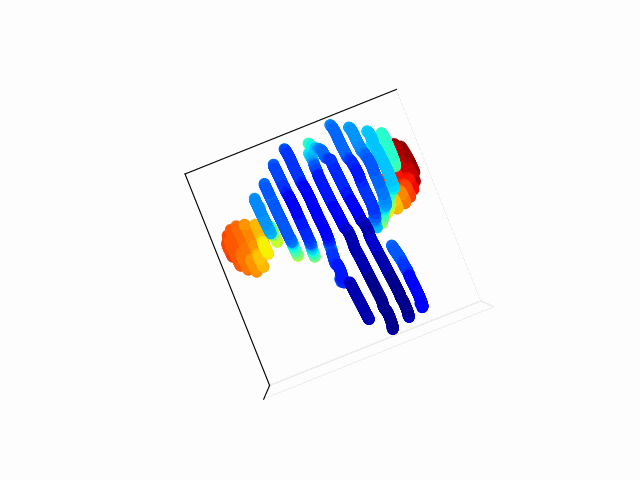

In [10]:
# Génération des points d'origine
pointsRight = eplRedPoints('scanRight/scan', epl)
pointsLeft = eplRedPoints('scanLeft/', epl)

# Calcul des points 3D
point = getObjectPoint(pointsRight, epl, camWorldCenterLeft, camWorldCenterRight, camLeft, camRight)

# Création d'un GIF en tournant les points
gif_path = createGifMonkey(point, num_frames=71, axis='y', angle_step=5, gif_path='rotation.gif')

display(pythImage(filename=gif_path))